In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **NEWS TAG PREDICTION**

**Description**

Tagging can be seen as the action of connecting a relevant user-defined keyword to a document, image or
video, which helps user to better organize and share their collections of interesting stuff. With the
rapid growth of Web 2.0, tagged data is becoming more and more abundant on the social network
websites. An interesting problem is how to automate the process of making tag recommendations
to users when a new resource becomes available. 

In this case study, a machine learning perspective is used to automate the process of tag recommendation for news articles.


**Problem Statement**

Suggest tags for the news articles based on the text content in the headline, synopsis and article text. 

## **DATA COLLECTION**
News articles were collected from [IndianExpress.com](https://indianexpress.com/) by scraping the web pages using BeautifulSoup API. The dataset contains 57530 news articles of various sections of the news.



In [ ]:
import requests
import urllib.request
import time
from bs4 import BeautifulSoup
import pickle
import concurrent.futures
import tqdm

def get_article_data(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    headline = soup.find_all(name = 'h1',attrs={'class':'native_story_title','itemprop':"headline"})[0].text
    location = soup.find_all(name = 'div',attrs = {"class":"editor","id":"storycenterbyline"})[0].text.split('|')[1].strip()
    date = soup.find_all(name = 'span',attrs = {'itemprop':"dateModified"} )[0].text.strip()
    synopsis = soup.find_all(name='h2',attrs={'itemprop':"description" ,'class':"synopsis"})[0].text

    #Extracting article text
    article_text = ""
    paragraphs = soup.find_all(name='p',attrs={})[:-2]
    for para in paragraphs:
      article_text+=para.text

    #Extracting tag and tag url associated with the news article
    story_tag = soup.find_all(name = 'div',attrs = {'class':"storytags"} )[0]
    a_element_list = story_tag.find_all(name = 'a')
    tag_list = []
    tag_link_list = []
    for a in a_element_list:
      tag_list.append(a.text)
      tag_link_list.append(a.attrs['href'])
    tags = ",".join(tag_list)
    tag_links = ",".join(tag_link_list)

    return url,headline,date,location,synopsis,article_text,tags,tag_links

def write_news_articles_to_file(urls):
    article_data = ""
    count = 0
    for i in tqdm.tnrange(0,len(urls)):
            try:
                tuple_data = get_article_data(urls[i])
                article_data = article_data + "\n"+"^".join(tuple_data)
                count+=1
                #Write to the file after every 100 news articles are retrieved
                if count == 100:
                  with open('/content/drive/My Drive/Applied ai case study/News_Tagging_Case_Study_1/Tagged_News_dataset.csv','a') as f:
                        f.write(article_data)
                        print('file write complete')
                  count = 0
                  article_data = ""
            except Exception as exc:
                print(i,urls[i], exc)


write_news_articles_to_file(filtered_tag_article_urls)

In [ ]:
import pickle

with open('/content/drive/My Drive/Applied ai case study/News_Tagging_Case_Study_1/india_section_news_article_urls.pickle','rb') as f:
  urls = pickle.load(f)

target=write_news_articles_to_file(urls)

In [ ]:
import pandas as pd

tagged_news_data = pd.read_csv('/content/drive/My Drive/Applied ai case study/News_Tagging_Case_Study_1/indianexpress_news_tagged_dataset.csv')

## **DATA ANALYSIS**

In [ ]:
tagged_news_data.columns

Index(['URL', 'HEADLINE', 'DATE', 'LOCATION', 'SYNOPSIS', 'ARTICLE_TEXT',
       'TAGS', 'TAG_LINKS'],
      dtype='object')

In [ ]:
tagged_news_data.shape

(57530, 8)

In [ ]:
tagged_news_data.head()

,URL,HEADLINE,DATE,LOCATION,SYNOPSIS,ARTICLE_TEXT,TAGS,TAG_LINKS
0,https://indianexpress.com/article/india/no-dis...,No disquiet among MLAs over ministerial berths...,"Updated: June 12, 2018 6:02:58 pm",Bengaluru,Not wishing to react on Kumaraswamy's statemen...,Former Karnataka Chief Minister Siddaramaiah o...,"Congress,Karnataka,Siddaramaiah","https://indianexpress.com/about/congress/,http..."
1,https://indianexpress.com/article/india/to-fly...,"To fly Amit Shah, Kargil hero fakes mail, BSF ...","Updated: August 27, 2019 10:02:35 am",New Delhi,"The probe was ordered when the BSF Air Wing, w...",A Kargil War hero from the Indian Air Force is...,"amit shah,Indian Air Force (IAF)","https://indianexpress.com/about/amit-shah/,htt..."
2,https://indianexpress.com/article/india/kalbur...,Kalburgi case probe: Final training camp in es...,"Updated: July 8, 2019 7:05:56 am",Bengaluru,Several persons arrested in the Gauri Lankesh ...,THE PROBE by a Special Investigation Team (SIT...,"Gauri Lankesh,M M Kalburgi",https://indianexpress.com/about/gauri-lankesh/...
3,https://indianexpress.com/article/india/intel-...,"Intel chiefs of Russia, China, Iran and Pakist...","Updated: July 12, 2018 6:03:00 am",New Delhi,The official confirmation of the meeting came ...,"Intelligence chiefs of Russia, China, Iran and...",Islamic State (IS),https://indianexpress.com/about/islamic-state-is/
4,https://indianexpress.com/article/india/naxal-...,Naxal commander killed in encounter with secur...,"Published: June 8, 2018 5:23:54 pm",Raipur,The gun-battle took place early Friday morning...,A naxal commander was on Friday gunned down in...,Naxal commander,https://indianexpress.com/about/naxal-commander/


**Count of unique tags**

In [ ]:
tag_count_dictionary = dict()

for tags in tagged_news_data['TAGS']:
  for tag in tags.split(','):
    if tag_count_dictionary.get(tag.strip()) == None:
      tag_count_dictionary[tag.strip()] = 1
    else:
      tag_count_dictionary[tag.strip()] += 1

In [ ]:
print('Total number of unique tags: ',len(tag_count_dictionary))

Total number of unique tags:  17681


**Number of news articles for each tag**

In [ ]:
tag_count_df = pd.DataFrame(data = list(tag_count_dictionary.items()),columns=['TAG','COUNT'])
tag_count_df

,TAG,COUNT
0,Congress,1080
1,Karnataka,177
2,Siddaramaiah,59
3,amit shah,533
4,Indian Air Force (IAF),37
...,...,...
17676,Telecom Regulatory Authority of India (Trai),1
17677,arab news,1
17678,yoga poses,1
17679,7/11 Mumbai serial blasts,1


**Using tags with atleast 10 news articles**

In [ ]:
tags = []
for tag,count in tag_count_dictionary.items():
    if count >= 10:
      tags.append(tag)

In [ ]:
len(tags)

2839

In [ ]:
TOTAL_TAGS = 2839

## TRAIN TEST SPLIT

In [ ]:
!pip install scikit-multilearn

In [ ]:
!pip install arff

In [ ]:
import numpy as np
X = []
Y = []

for i in range(tagged_news_data.shape[0]):
  labels = tagged_news_data['TAGS'][i].split(',')
  count = 0
  y = np.zeros(TOTAL_TAGS)
  for label in labels:
    if label in tags:
        y[tags.index(label)] = 1
        count+=1

  if count > 0:
    X.append([tagged_news_data['HEADLINE'][i],tagged_news_data['SYNOPSIS'][i], tagged_news_data['ARTICLE_TEXT'][i]])
    Y.append(y)

In [ ]:
import pandas as pd

X_np_array = pd.DataFrame(data = X,columns=['HEADLINE', 'SYNOPSIS', 'ARTICLE_TEXT']).values

In [ ]:
X_np_array.shape, len(Y)

((48205, 3), 48205)

In [ ]:
from skmultilearn.model_selection import iterative_train_test_split
import numpy as np

X_train, y_train, X_test, y_test = iterative_train_test_split(X_np_array, np.array(Y), test_size = 0.2)

In [ ]:
X_train, y_train, X_val, y_val = iterative_train_test_split(X_train, y_train, test_size = 0.1)

In [ ]:
X_train.shape,X_val.shape,X_test.shape

((32110, 3), (4965, 3), (11130, 3))

In [ ]:
y_train.shape,y_val.shape,y_test.shape

((32110, 2839), (4965, 2839), (11130, 2839))

In [ ]:
# import numpy as np

# np.save('/content/drive/MyDrive/Applied ai case study/News_Tagging_Case_Study_1/X_train.npy',X_train)
# np.save('/content/drive/MyDrive/Applied ai case study/News_Tagging_Case_Study_1/X_val.npy',X_val)
# np.save('/content/drive/MyDrive/Applied ai case study/News_Tagging_Case_Study_1/X_test.npy',X_test)


# np.save('/content/drive/MyDrive/Applied ai case study/News_Tagging_Case_Study_1/y_train.npy',y_train)
# np.save('/content/drive/MyDrive/Applied ai case study/News_Tagging_Case_Study_1/y_val.npy',y_val)
# np.save('/content/drive/MyDrive/Applied ai case study/News_Tagging_Case_Study_1/y_test.npy',y_test)

## TEXT PREPROCESSING

In [ ]:
import numpy as np
import pickle

X_train = np.load('/content/drive/MyDrive/Applied ai case study/News_Tagging_Case_Study_1/X_train.npy',allow_pickle=True)
X_val   = np.load('/content/drive/MyDrive/Applied ai case study/News_Tagging_Case_Study_1/X_val.npy',allow_pickle=True)
X_test  = np.load('/content/drive/MyDrive/Applied ai case study/News_Tagging_Case_Study_1/X_test.npy',allow_pickle=True)

y_train = np.load('/content/drive/MyDrive/Applied ai case study/News_Tagging_Case_Study_1/y_train.npy')
y_val   = np.load('/content/drive/MyDrive/Applied ai case study/News_Tagging_Case_Study_1/y_val.npy')
y_test  = np.load('/content/drive/MyDrive/Applied ai case study/News_Tagging_Case_Study_1/y_test.npy')

In [ ]:
import re

def decontracted(phrase):
        phrase = re.sub(r"n\'t", " not", phrase)
        phrase = re.sub(r"\'re", " are", phrase)
        phrase = re.sub(r"\'s", " is", phrase)
        phrase = re.sub(r"\'d", " would", phrase)
        phrase = re.sub(r"\'ll", " will", phrase)
        phrase = re.sub(r"\'t", " not", phrase)
        phrase = re.sub(r"\'ve", " have", phrase)
        phrase = re.sub(r"\'m", " am", phrase)
        return phrase

def preprocess_text(text):
  # lowercase
  text = text.lower()
  # Remove urls
  pattern=r'(?i)\b((?:[a-z][\w-]+:(?:/{1,3}|[a-z0-9%])|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))'
  text = re.sub(pattern, " ",text)
  # keep only aphabetical characters
  text = re.sub("[^a-z]",' ',text)
  # decontract words
  text = decontracted(text)
  return text.strip()

In [ ]:
for i in range(X_train.shape[0]):
  X_train[i][0] = preprocess_text(X_train[i][0])
  X_train[i][1] = preprocess_text(X_train[i][1])
  X_train[i][2] = preprocess_text(X_train[i][2])  

In [ ]:
for i in range(X_val.shape[0]):
  X_val[i][0] = preprocess_text(X_val[i][0])
  X_val[i][1] = preprocess_text(X_val[i][1])
  X_val[i][2] = preprocess_text(X_val[i][2])  

In [ ]:
for i in range(X_test.shape[0]):
  X_test[i][0] = preprocess_text(X_test[i][0])
  X_test[i][1] = preprocess_text(X_test[i][1])
  X_test[i][2] = preprocess_text(X_test[i][2])  

## TOKENIZATION

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train[:,2])

In [ ]:
print("Unique number of tokens in the data: ",len(tokenizer.word_index))

Unique number of tokens in the data:  118903


In [ ]:
X_train_sequence = tokenizer.texts_to_sequences(X_train[:,2])
X_val_sequence = tokenizer.texts_to_sequences(X_val[:,2])
X_test_sequence = tokenizer.texts_to_sequences(X_test[:,2])

In [ ]:
# MAX_SEQUENCE_LENGTH = 0
# SEQUENCE_LENGTHS = []
# for seq in X_train_sequence:
#   SEQUENCE_LENGTHS.append(len(seq))
#   if len(seq) > MAX_SEQUENCE_LENGTH:
#     MAX_SEQUENCE_LENGTH = len(seq)

# MAX_SEQUENCE_LENGTH

8088

(array([3.0107e+04, 1.8640e+03, 9.3000e+01, 3.5000e+01, 6.0000e+00,
        4.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  16. ,  823.2, 1630.4, 2437.6, 3244.8, 4052. , 4859.2, 5666.4,
        6473.6, 7280.8, 8088. ]),
 <a list of 10 Patch objects>)

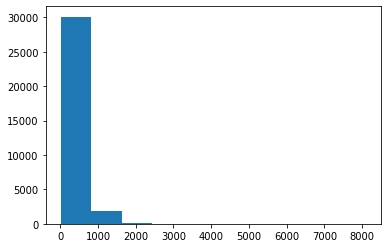

In [ ]:
# import matplotlib.pyplot as plt

# plt.hist(SEQUENCE_LENGTHS)

In [ ]:
count = 0
for seq in X_train_sequence:
  if len(seq) <= 1000:
    count+=1
count/len(X_train_sequence)

0.9709436312675179

In [ ]:
count = 0
for seq in X_val_sequence:
  if len(seq) <= 1000:
    count+=1
count/len(X_val_sequence)

0.9784491440080564

In [ ]:
count = 0
for seq in X_test_sequence:
  if len(seq) <= 1000:
    count+=1
count/len(X_test_sequence)

0.9751123090745732

In [ ]:
MAX_SEQUENCE_LENGTH = 1000

In [ ]:
X_train_seq = pad_sequences(X_train_sequence, maxlen=MAX_SEQUENCE_LENGTH,padding = 'post')
X_val_seq   = pad_sequences(X_val_sequence, maxlen=MAX_SEQUENCE_LENGTH,padding = 'post')
X_test_seq  = pad_sequences(X_test_sequence, maxlen=MAX_SEQUENCE_LENGTH,padding = 'post')

## EMBEDDING

In [ ]:
# import gensim.models
# sentences = []
# for x in X_train[:,2]:
#   sentences.append(x.split())
# skipGramModel = gensim.models.Word2Vec(sentences=sentences,sg = 1,workers=16,iter = 50,window=10,min_count = 1)

In [ ]:
# skipGramModel.wv.save_word2vec_format(fname='/content/drive/MyDrive/Applied ai case study/News_Tagging_Case_Study_1/word_vectors.bin',binary=True)

In [ ]:
len(skipGramModel.wv.vocab)

118903

In [ ]:
skipGramModel = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Applied ai case study/News_Tagging_Case_Study_1/word_vectors.bin',binary=True)

In [ ]:
# #create embedding matrix
# import numpy as np
# EMBEDDING_DIM = 100
# word_index = tokenizer.word_index
# embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
# for word, i in word_index.items():
#     try:
#       embedding_vector = skipGramModel.wv.get_vector(word)
#       embedding_matrix[i] = embedding_vector
#     except:
#       pass

In [ ]:
# np.save('/content/drive/MyDrive/Applied ai case study/News_Tagging_Case_Study_1/embedding_matrix.npy',embedding_matrix)

In [ ]:
import numpy as np
EMBEDDING_DIM = 100
word_index = tokenizer.word_index
embedding_matrix = np.load('/content/drive/MyDrive/Applied ai case study/News_Tagging_Case_Study_1/embedding_matrix.npy')

## MODELS

### BI-LSTM MULTI LABEL CLASSIFICATION

In [ ]:
import tensorflow as tf

tf.keras.backend.clear_session()

BILSTM_HIDDEN_UNITS = 10

text_input = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
#Using Word2Vec Model as pretrained embedding 
embedding_layer = tf.keras.layers.Embedding(len(word_index) + 1,
                                            EMBEDDING_DIM,
                                            weights=[embedding_matrix],
                                            input_length=MAX_SEQUENCE_LENGTH,
                                            trainable=True)


embedded_text_input = embedding_layer(text_input)

bilstm_output = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(BILSTM_HIDDEN_UNITS,return_sequences=True))(embedded_text_input)

flattened_output = tf.keras.layers.Flatten()(bilstm_output)

dense_output_1 = tf.keras.layers.Dense(units = 512, activation='sigmoid')(flattened_output)
dense_output_2 = tf.keras.layers.Dense(units = 256, activation='sigmoid')(dense_output_1)
final_output   = tf.keras.layers.Dense(units = 2839, activation='sigmoid')(dense_output_2)

model = tf.keras.models.Model(inputs=text_input, outputs=final_output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 1000, 100)         11890400  
_________________________________________________________________
bidirectional (Bidirectional (None, 1000, 20)          8880      
_________________________________________________________________
flatten (Flatten)            (None, 20000)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               10240512  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 2839)              729623

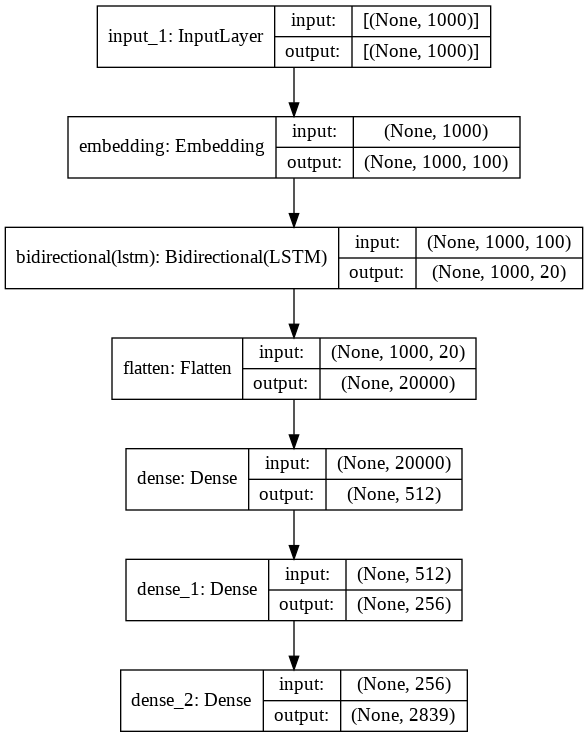

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import Image
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)
Image('model.png')

In [ ]:
import tensorflow_addons as tfa
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
              metrics = ['accuracy',tfa.metrics.F1Score(num_classes = 2839,threshold = 0.5,average='weighted')])

In [ ]:
# import numpy as np

# model.fit(X_train_seq,y_train,
#           validation_data = (X_val_seq, y_val),
#           batch_size = 32,
#           epochs = 10,
#           verbose = True,
#           shuffle = True)

Epoch 1/10
1004/1004 [==============================] - 537s 532ms/step - loss: 0.0309 - accuracy: 0.0380 - val_loss: 0.0038 - val_accuracy: 0.0312
Epoch 2/10
1004/1004 [==============================] - 538s 536ms/step - loss: 0.0051 - accuracy: 0.0405 - val_loss: 0.0038 - val_accuracy: 0.0304
Epoch 3/10
1004/1004 [==============================] - 537s 535ms/step - loss: 0.0051 - accuracy: 0.0404 - val_loss: 0.0038 - val_accuracy: 0.0304
Epoch 4/10
1004/1004 [==============================] - 537s 535ms/step - loss: 0.0052 - accuracy: 0.0425 - val_loss: 0.0038 - val_accuracy: 0.0312
Epoch 5/10
1004/1004 [==============================] - 539s 536ms/step - loss: 0.0052 - accuracy: 0.0426 - val_loss: 0.0038 - val_accuracy: 0.0304
Epoch 6/10
1004/1004 [==============================] - 538s 536ms/step - loss: 0.0052 - accuracy: 0.0387 - val_loss: 0.0038 - val_accuracy: 0.0304
Epoch 7/10
1004/1004 [==============================] - 538s 536ms/step - loss: 0.0052 - accuracy: 0.0437 - val_

In [ ]:
model.load_weights('/content/drive/MyDrive/Applied ai case study/News_Tagging_Case_Study_1/model.h5')

In [ ]:
import numpy as np

model.fit(X_train_seq,y_train,
          validation_data = (X_val_seq, y_val),
          batch_size = 32,
          epochs = 15,
          verbose = True,
          shuffle = True,initial_epoch = 10)

Epoch 11/15
1004/1004 [==============================] - 149s 145ms/step - loss: 0.0042 - accuracy: 0.1638 - f1_score: 0.0598 - val_loss: 0.0026 - val_accuracy: 0.1940 - val_f1_score: 0.0790
Epoch 12/15
1004/1004 [==============================] - 145s 145ms/step - loss: 0.0032 - accuracy: 0.2600 - f1_score: 0.1309 - val_loss: 0.0024 - val_accuracy: 0.2171 - val_f1_score: 0.1309
Epoch 13/15
1004/1004 [==============================] - 145s 145ms/step - loss: 0.0027 - accuracy: 0.3274 - f1_score: 0.2117 - val_loss: 0.0024 - val_accuracy: 0.2314 - val_f1_score: 0.1720
Epoch 14/15
1004/1004 [==============================] - 144s 143ms/step - loss: 0.0022 - accuracy: 0.4043 - f1_score: 0.3094 - val_loss: 0.0025 - val_accuracy: 0.2274 - val_f1_score: 0.1787
Epoch 15/15
1004/1004 [==============================] - 143s 143ms/step - loss: 0.0018 - accuracy: 0.4701 - f1_score: 0.4110 - val_loss: 0.0027 - val_accuracy: 0.2161 - val_f1_score: 0.1959


In [ ]:
# model.save_weights('/content/drive/MyDrive/Applied ai case study/News_Tagging_Case_Study_1/model.h5')

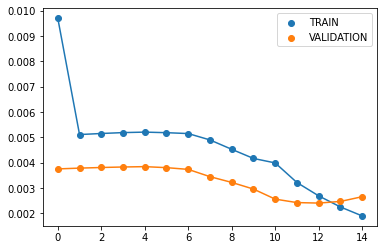

In [ ]:
import matplotlib.pyplot as plt

plt.scatter([i for i in range(15)],train_loss[0:15],label = 'TRAIN')
plt.plot([i for i in range(15)],train_loss[0:15])

plt.scatter([i for i in range(15)],val_loss[0:15],label = 'VALIDATION')
plt.plot([i for i in range(15)],val_loss[0:15])

plt.legend()
plt.show()

In [ ]:
y_test_pred = model.predict(X_test_seq)

In [ ]:
y_test_pred_classes = y_test_pred.copy()
for i in range(y_test_pred_classes.shape[0]):
  for j in range(y_test_pred.shape[1]):
    if y_test_pred[i][j] > 0.5:
      y_test_pred_classes[i][j] = 1
    else:
      y_test_pred_classes[i][j] = 0

In [ ]:
from sklearn.metrics import  classification_report

class_report = classification_report(y_test, y_test_pred_classes, output_dict=True)
report = pd.DataFrame(data = class_report)
report[['micro avg',	'macro avg','weighted avg',	'samples avg']]

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,micro avg,macro avg,weighted avg,samples avg
precision,0.370921,0.116513,0.258234,0.203206
recall,0.180285,0.081054,0.180285,0.175135
f1-score,0.242637,0.085483,0.197770,0.174335
support,17023.000000,17023.000000,17023.000000,17023.000000


### **ZERO SHOT TEXT CLASSIFICATION**
[TRAIN ONCE, TEST ANYWHERE: ZERO-SHOT LEARNING FOR TEXT CLASSIFICATION](https://arxiv.org/pdf/1712.05972.pdf)


In [ ]:
import pandas as pd

tagged_news_data = pd.read_csv('/content/drive/My Drive/Applied ai case study/News_Tagging_Case_Study_1/indianexpress_news_tagged_dataset.csv')
tagged_news_data[['ARTICLE_TEXT',
       'TAGS']].tail()

,ARTICLE_TEXT,TAGS
57525,No claimants have come forward for about a doz...,swiss account
57526,"Mohammed Ali Shaikh,an accused in the 7/11 Mum...","2006 Malegaon blasts,7/11 Mumbai serial blasts..."
57527,The National Company Law Appellate Tribunal (N...,"Cyrus Mistry,Tata Group"
57528,The Bombay High Court today suggested the Maha...,"Bombay High Court,Maharashtra government,Skype..."
57529,The Supreme Court Friday issued a notice to Co...,"kiran bedi,Puducherry,V Narayanswamy"


In [ ]:
count = 0
for y in y_train:
  count+=np.count_nonzero(y)
count

61763

In [ ]:
count = 0
for y in y_val:
  count+=np.count_nonzero(y)
count

6725

In [ ]:
count = 0
for y in y_test:
  count+=np.count_nonzero(y)
count

17023

In [ ]:
import random
import numpy as np

# generating training data for zero shot

def preprocess_tokenize_tag(tokenizer,tag):
  tag = preprocess_text(tag)
  tag_sequence = tokenizer.texts_to_sequences([tag])
  tag_sequence = pad_sequences(tag_sequence, maxlen=5,padding = 'post')
  return tag_sequence[0]

def get_zero_shot_data(X,tags,y,tokenizer,shape):
  X_article_text = np.zeros((shape*6,1000))
  X_tags = np.zeros((shape*6,5))
  binary_labels = []
  index_to_original_tag_dict = dict()
  index = 0
  for i in range(X.shape[0]):
    # All tags related to the article
    text_labels = []
    for j in range(y.shape[1]):
      if y[i][j] == 1:
        text_labels.append(tags[j])
    
    # pair the article with some random unrelated tags 
    # set the binary label to 0
    for label in text_labels:
        X_article_text[index] = X[i]
        tokens = preprocess_tokenize_tag(tokenizer,label)
        X_tags[index] = tokens
        index_to_original_tag_dict[tuple(tokens)] = label
        index+=1
        binary_labels.append(1)
        for k in range(5):
          while True:
            random_tag = tags[random.randint(0,len(tags)-1)]
            if random_tag not in text_labels:
              X_article_text[index] = X[i]
              tokens = preprocess_tokenize_tag(tokenizer,random_tag)
              X_tags[index] = tokens
              index_to_original_tag_dict[tuple(tokens)] = random_tag
              index+=1
              binary_labels.append(0)
              break

  return X_article_text,X_tags,binary_labels,index_to_original_tag_dict


X_train_zs,X_train_tags,y_train_labels,index_to_original_tag_dict_train = get_zero_shot_data(X_train_seq,tags,y_train,tokenizer,61763)
X_val_zs,X_val_tags,y_val_labels,index_to_original_tag_dict_val = get_zero_shot_data(X_val_seq,tags,y_val,tokenizer,6725)
X_test_zs,X_test_tags,y_test_labels,index_to_original_tag_dict_test = get_zero_shot_data(X_test_seq,tags,y_test,tokenizer,17023)

In [ ]:
import numpy as np
EMBEDDING_DIM = 100
word_index = tokenizer.word_index
embedding_matrix = np.load('/content/drive/MyDrive/Applied ai case study/News_Tagging_Case_Study_1/embedding_matrix.npy')

In [ ]:
import tensorflow as tf
from keras import initializers

tf.keras.backend.clear_session()

article_text_input = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
tag_text_input = tf.keras.layers.Input(shape=(5,), dtype='int32')

#Using Word2Vec Model as pretrained embedding 
article_embedding_layer = tf.keras.layers.Embedding(len(word_index) + 1,
                                            EMBEDDING_DIM,
                                            weights=[embedding_matrix],
                                            input_length=MAX_SEQUENCE_LENGTH,
                                            trainable=True)

tag_embedding_layer = tf.keras.layers.Embedding(len(word_index) + 1,
                                            EMBEDDING_DIM,
                                            weights=[embedding_matrix],
                                            input_length=5,
                                            trainable=True)

embedded_article_text_input = article_embedding_layer(article_text_input)
embedded_tag_text_input = tag_embedding_layer(tag_text_input)

article_bilstm_output = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10,return_sequences=True))(embedded_article_text_input)
tag_bilstm_output     = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(5,return_sequences=True))(embedded_tag_text_input)

article_bilstm_output = tf.keras.layers.Flatten()(article_bilstm_output)
tag_bilstm_output = tf.keras.layers.Flatten()(tag_bilstm_output)

article_tag_concat = tf.keras.layers.Concatenate()([article_bilstm_output,tag_bilstm_output])

dense_output_1 = tf.keras.layers.Dense(units = 512, activation='sigmoid')(article_tag_concat)
dense_output_2 = tf.keras.layers.Dense(units = 256, activation='sigmoid')(dense_output_1)
final_output   = tf.keras.layers.Dense(units = 1, activation='sigmoid')(dense_output_2)

model = tf.keras.models.Model(inputs=[article_text_input,tag_text_input], outputs=final_output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1000, 100)    11890400    input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 5, 100)       11890400    input_2[0][0]                    
______________________________________________________________________________________________

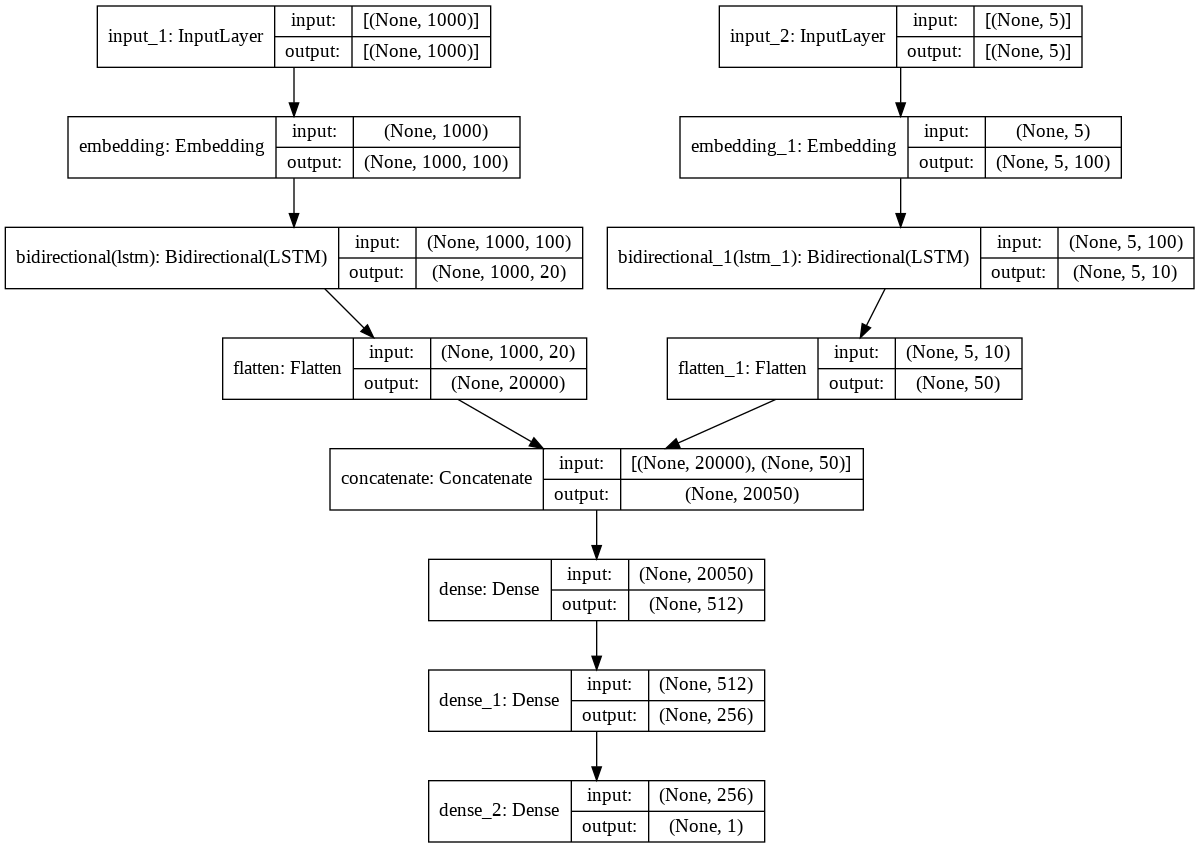

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import Image
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)
Image('model.png')

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              metrics = ['accuracy'])

In [ ]:
import numpy as np

model.fit([X_train_zs,X_train_tags],np.array(y_train_labels),
          validation_data = ([X_val_zs,X_val_tags],np.array(y_val_labels)),
          batch_size = 1024,
          epochs = 10,
          verbose = True,
          shuffle = True)

Epoch 1/10
362/362 [==============================] - 168s 450ms/step - loss: 0.4404 - accuracy: 0.8300 - val_loss: 0.3655 - val_accuracy: 0.8640
Epoch 2/10
362/362 [==============================] - 161s 444ms/step - loss: 0.3553 - accuracy: 0.8666 - val_loss: 0.3192 - val_accuracy: 0.8727
Epoch 3/10
362/362 [==============================] - 160s 442ms/step - loss: 0.3141 - accuracy: 0.8743 - val_loss: 0.2987 - val_accuracy: 0.8781
Epoch 4/10
362/362 [==============================] - 160s 442ms/step - loss: 0.2862 - accuracy: 0.8813 - val_loss: 0.2829 - val_accuracy: 0.8829
Epoch 5/10
362/362 [==============================] - 160s 441ms/step - loss: 0.2599 - accuracy: 0.8888 - val_loss: 0.2647 - val_accuracy: 0.8872
Epoch 6/10
362/362 [==============================] - 159s 439ms/step - loss: 0.2218 - accuracy: 0.9020 - val_loss: 0.2427 - val_accuracy: 0.8972
Epoch 7/10
362/362 [==============================] - 159s 440ms/step - loss: 0.1824 - accuracy: 0.9212 - val_loss: 0.2279 -

In [ ]:
# model.save_weights('/content/drive/MyDrive/Applied ai case study/News_Tagging_Case_Study_1/model_zs.h5')

In [ ]:
# model.load_weights('/content/drive/MyDrive/Applied ai case study/News_Tagging_Case_Study_1/model_zs.h5')

In [ ]:
model.evaluate([X_test_zs,X_test_tags],np.array(y_test_labels))

3192/3192 [==============================] - 89s 28ms/step - loss: 0.2588 - accuracy: 0.9061


[0.2587941586971283, 0.9060878157615662]

In [ ]:
y_test_pred = model.predict([X_test_zs,X_test_tags])

In [ ]:
import numpy as np
y_test_pred_multilabel = []
k = 0
for i in range(y_test.shape[0]):
  label = np.zeros(2839)
  label_count = np.count_nonzero(y_test[i])
  for j in range(6*label_count):
    tokens = tuple(X_test_tags[k])
    tag = index_to_original_tag_dict_test[tokens]
    if y_test_pred[k] > 0.5:
      label[tags.index(tag)] = 1
    k+=1
  y_test_pred_multilabel.append(label)

In [ ]:
from sklearn.metrics import  classification_report

class_report = classification_report(y_test, y_test_pred_multilabel, output_dict=True)
report = pd.DataFrame(data = class_report)
report[['micro avg',	'macro avg','weighted avg',	'samples avg']]

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,micro avg,macro avg,weighted avg,samples avg
precision,0.714433,0.548202,0.692368,0.615240
recall,0.692064,0.503616,0.692064,0.666233
f1-score,0.703070,0.500273,0.675779,0.621518
support,17023.000000,17023.000000,17023.000000,17023.000000
